In [1]:
import soundfile as sf

import librosa
import numpy as np

from pathlib import Path
from IPython.display import Audio

In [2]:
import matplotlib.pyplot as plt
from math import ceil

In [3]:
import os
# Keep GPU off (so TF stays on CPU)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# Let TF use fast CPU kernels (oneDNN). Comment the next line if you need exact reproducibility.
os.environ.pop("TF_ENABLE_ONEDNN_OPTS", None)


In [4]:
# #from transformers import EncodecModel
# #import torch
# ###########   This subprocess nonsense is because we can't import torch into the same environment as param2 ! :-(
# import subprocess
# import pickle
import torch

In [5]:
from workflow.writeParamArrays import write_sidecar_features

<div style="width: 100%; height: 5px; background-color: DarkBlue;"></div>
<b>Parameters</b>

In [6]:
sample_rate=24000
hop_length_samples = int(sample_rate / 75)
hop_length_ms = 1000/75

LOWPVAL1=-60 # open G3 low violin string
HIPVAL1=0 # Octave above E5 high violin string

LOWPVAL2=38 # open G3 low violin string
HIPVAL2=127 # Octave above E5 high violin string


<div style="width: 100%; height: 5px; background-color: DarkBlue;"></div>
<b>read wav file</b><br>

In [7]:
WRITE_FEATURES = True  #save features to sidecar (.json and .npy) files
audio_root=Path('./datasets/')
fname = 'III_Corrente' #This is the ONE we will work on in this notebook - (you'll probably loop over a folder of files in your code)
inputwav= Path('wav/', fname+ '.wav')    # this path is relative to the audio_ROOT
inputecdc= Path("ecdc/", fname+ '.ecdc') # this path is relative to the audio_ROOT

print(f'audio_root={audio_root}, fname={fname}, inputwav={inputwav}, inputecdc={inputecdc}')
print('========')
!ls {Path(audio_root, 'wav/')}

audio_root=datasets, fname=III_Corrente, inputwav=wav/III_Corrente.wav, inputecdc=ecdc/III_Corrente.ecdc
II_Double.wav	  IV_Double_Presto.wav	VIII_Double.wav
III_Corrente.wav  VI_Double.wav


In [8]:
print(f'Will process {Path(audio_root, inputwav)}')
audio, sr = sf.read(Path(audio_root, inputwav))
assert sr==sample_rate

print(f'audio length in samples is {len(audio)} and in frames is {ceil(len(audio)/320)}')

Will process datasets/wav/III_Corrente.wav
audio length in samples is 4880117 and in frames is 15251


<div style="width: 100%; height: 5px; background-color: DarkBlue;"></div>
<b>read ecdc file</b><br>

In [9]:
# Load .ecdc via subprocess (no torch in this environment)
print(f'ecdc file is {inputecdc}')
# result = subprocess.run(
#     ['python', 'load_ecdc.py', Path(audio_root, inputecdc)],
#     capture_output=True,
#     check=True
# )
# # Deserialize the data
# saved_data = pickle.loads(result.stdout)

saved_data = torch.load(Path(audio_root, inputecdc))

print(f'Shape of code data is {saved_data['audio_codes'].shape}')
ecdc_cb1=saved_data['audio_codes'][0,0,0,:] # grab first codebook tokens over time
NUMFRAMES=len(ecdc_cb1)
print(f'ecdc length in frames is {NUMFRAMES}')
print(f'MAKE SURE YOUR PARAMETER LISTS ARE THIS LENGTH, {NUMFRAMES}')
ecdc_cb1.shape

ecdc file is ecdc/III_Corrente.ecdc
Shape of code data is torch.Size([1, 1, 8, 15251])
ecdc length in frames is 15251
MAKE SURE YOUR PARAMETER LISTS ARE THIS LENGTH, 15251


torch.Size([15251])

In [10]:
###   Helper functions  ###
###########################

def freq_to_midi(freq, low_note=55, hi_note=88): #low G3 open to octave above high E5 open
    """Convert frequency array to MIDI note numbers, clipped to range"""
    midi = 69 + 12 * np.log2(freq / 440.0)
    return np.clip(midi, low_note, hi_note)

def rms_to_db_cliprel(rms, clipsd=3):
    rms_db=(20.0 * np.log10(rms + 1e-12)).astype(np.float32) #le'ts do db
    clipped = np.clip(rms_db, rms_db.mean() - clipsd*rms_db.std(), rms_db.mean() + clipsd*rms_db.std())
    return clipped
    
def rms_to_db_clipabs(rms, cliplow=40, cliphi=80):
    rms_db=(20.0 * np.log10(rms + 1e-12)).astype(np.float32) #le'ts do db
    clipped=np.clip(rms_db, cliplow, cliphi)
    return clipped

<div style="width: 100%; height: 5px; background-color: DarkBlue;"></div>
<b>RMS</b>

In [11]:
# RMS from LIBROSA
rms = librosa.feature.rms(y=audio, center=True, hop_length=hop_length_samples)[0]
dbrms=rms_to_db_cliprel(rms)
if len(dbrms) != NUMFRAMES :
    print(f' Must adjust parameter list length to match NUMFRAMES')
time_rms = librosa.frames_to_time(np.arange(len(dbrms)), sr=sr, hop_length=320)

print(f"Sample rate: {sr} /s")
print(f"Audio duration: {len(audio)/sr:.2f} seconds")
print(f"Number of dbrms frames: {len(dbrms)}")
print(f"dbrms frame rate: {len(dbrms) / (len(audio)/sr):.2f} fps")

Sample rate: 24000 /s
Audio duration: 203.34 seconds
Number of dbrms frames: 15251
dbrms frame rate: 75.00 fps


In [12]:
dbrms.max()

np.float32(-6.88482)

<div style="width: 100%; height: 5px; background-color: DarkBlue;"></div>
<b>let's make a second param list</b>

Of course, parameters could come from anywhere - parsed file names, linear glides from the beginning to the end of the wave file, whatever.

In [13]:
# a rising noodle of midi note numbers, porque no:
param2 = np.linspace(60, 120, NUMFRAMES) + np.random.uniform(-5, 5,  NUMFRAMES)
time_param2 = librosa.frames_to_time(np.arange(NUMFRAMES), sr=sr, hop_length=320)

<div style="width: 100%; height: 5px; background-color: DarkBlue;"></div>
<b>Lets visualize what we have</b>

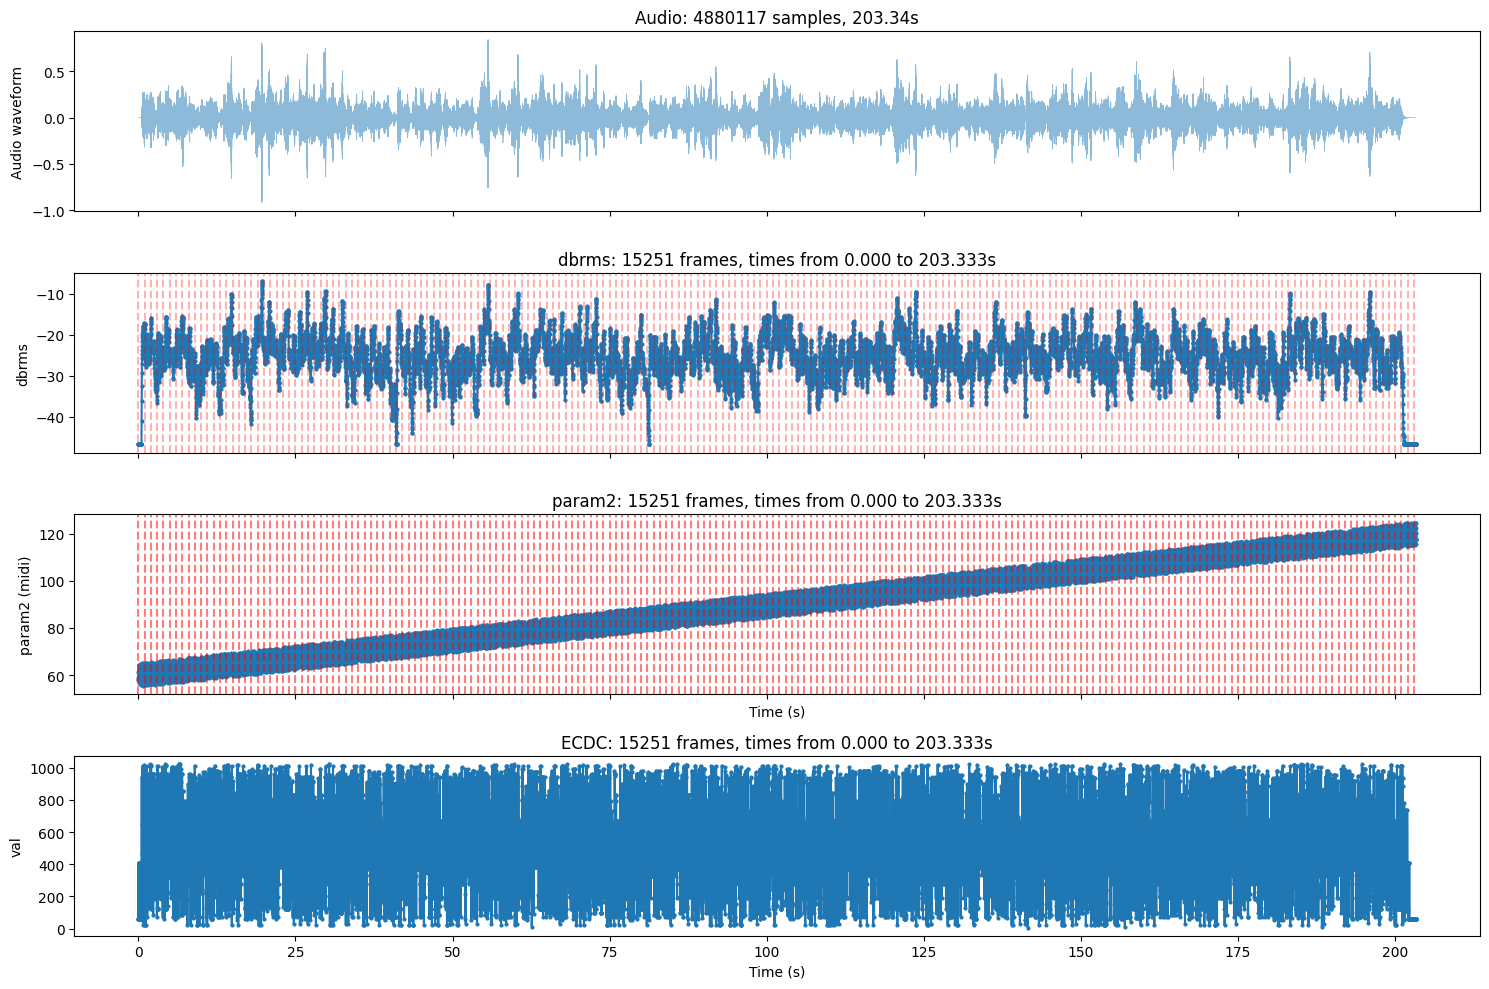


Audio: 4880117 samples = 203.338 seconds

RMS:
  Frames: 15251
  First frame at: 0.0000s
  Last frame at: 203.3333s
  Frame spacing: 0.0133s

param2:
  Frames: 15251
  First frame at: 0.0000s
  Last frame at: 203.3333s
  Frame spacing: 0.0133s

Time offset: 0.0000s


In [14]:

# Plot alignment check
fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

# Plot waveform
time_audio = np.arange(len(audio)) / sr
axes[0].plot(time_audio, audio, alpha=0.5, linewidth=0.5)
axes[0].set_ylabel('Audio waveform')
axes[0].set_title(f'Audio: {len(audio)} samples, {len(audio)/sr:.2f}s')

# Plot dbrms with vertical lines at frame centers
axes[1].plot(time_rms, dbrms, 'o-', markersize=2)
axes[1].set_ylabel('dbrms')
axes[1].set_title(f'dbrms: {len(dbrms)} frames, times from {time_rms[0]:.3f} to {time_rms[-1]:.3f}s')
for t in time_rms[::75]:  # Mark every second
    axes[1].axvline(t, color='r', alpha=0.3, linestyle='--')

# Plot param2 param2 with vertical lines at frame centers
axes[2].plot(time_param2, param2, 'o-', markersize=2)
axes[2].set_ylabel('param2 (midi)')
axes[2].set_xlabel('Time (s)')
axes[2].set_title(f'param2: {NUMFRAMES} frames, times from {time_param2[0]:.3f} to {time_param2[-1]:.3f}s')
for t in time_param2[::75]:  # Mark every second
    axes[2].axvline(t, color='r', alpha=0.3, linestyle='--')

# Plot ECDC cb1 vals with vertical lines at frame centers (has same time values per frame as dbrms
axes[3].plot(time_rms, ecdc_cb1, 'o-', markersize=2)
axes[3].set_ylabel('val')
axes[3].set_xlabel('Time (s)')
axes[3].set_title(f'ECDC: {NUMFRAMES} frames, times from {time_rms[0]:.3f} to {time_rms[-1]:.3f}s')
for t in time_rms[::75]:  # Mark every second
    axes[2].axvline(t, color='r', alpha=0.3, linestyle='--')


plt.tight_layout()

###   ZOOM !!!   ####
#axes[0].set_xlim(180, 195)  # This works fine without widgets
###              ###

plt.show()

# Print detailed timing info
print(f"\nAudio: {len(audio)} samples = {len(audio)/sr:.3f} seconds")
print(f"\nRMS:")
print(f"  Frames: {NUMFRAMES}")
print(f"  First frame at: {time_rms[0]:.4f}s")
print(f"  Last frame at: {time_rms[-1]:.4f}s")
print(f"  Frame spacing: {time_rms[1] - time_rms[0]:.4f}s")
print(f"\nparam2:")
print(f"  Frames: {NUMFRAMES}")
print(f"  First frame at: {time_param2[0]:.4f}s")
print(f"  Last frame at: {time_param2[-1]:.4f}s")
print(f"  Frame spacing: {time_param2[1] - time_param2[0]:.4f}s")
print(f"\nTime offset: {abs(time_param2[0] - time_rms[0]):.4f}s")

<div style="width: 100%; height: 5px; background-color: DarkBlue;"></div>
<b>Write - the crux of the matter</b>

In [15]:
feats = {
    "amp" : {
        "values" : dbrms,
        "units" : "dB (20.0 * np.log10(rms + 1e-12))",
        "min" : LOWPVAL1,
        "max" : HIPVAL1
    },
    "param2": {
        "values": param2, # param2 always adds frames at the end. Force to be same length 
        "units": "midi",
        "doc_string": "Clamped any param2es out of range",
        "min" : LOWPVAL2, # low string on violin
        "max" : HIPVAL2 # octave above high string on violin
    }
}

if WRITE_FEATURES == True : 
    path=Path(audio_root, inputecdc)
    print(f' audio_root = {audio_root}, ecdc_rel = {inputecdc}, path to ecdc = {path}')
    
    !ls ./audio/ecdc/II_Double.ecdc
    !ls "{path}"
    
    write_sidecar_features(
        root=audio_root,
        ecdc_rel=inputecdc,
        features=feats,
        fps=75.0,
        mode="overwrite", # overwrite parameters with the same name as you are saving (still leaves others intact)
        require_ecdc_exists=True,  # set True if you want a safety check
    )


 audio_root = datasets, ecdc_rel = ecdc/III_Corrente.ecdc, path to ecdc = datasets/ecdc/III_Corrente.ecdc
ls: cannot access './audio/ecdc/II_Double.ecdc': No such file or directory
datasets/ecdc/III_Corrente.ecdc


<div style="width: 100%; height: 5px; background-color: DarkBlue;"></div>
<b>A AUDIO test of parameter alignment</b>
Note: Click to play!!

In [16]:
#%matplotlib inline
#%matplotlib notebook
%matplotlib widget

# # #---------------------- All
# fooaudio=audio
# foodbrms=dbrms
# fooparam2=param2

# ------------------------------

#-------------------------Middle
# startpos = 120
# dur=3

# startframe=startpos*75
# endframe=startframe+dur*75

# fooaudio=audio[startframe*320:endframe*320]
# foodbrms=dbrms[startframe:endframe]
# fooparam2=param2[startframe:endframe]


# #---------------------- last chunk
fooaudio=audio[-5*75*320:]
foodbrms=dbrms[-5*75:]
fooparam2=param2[-5*75:]

In [17]:
len(fooaudio)

120000

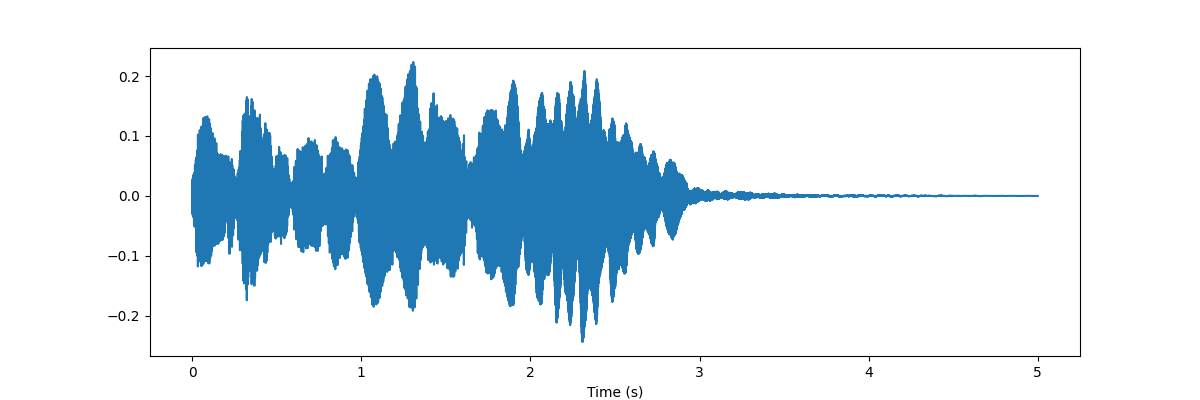

In [18]:
import matplotlib.pyplot as plt
import sounddevice as sd

def clickable_audio_player(audio, sr, data_to_plot=None):
    """Click on plot to play from that position"""
    if data_to_plot is None:
        data_to_plot = audio
    
    time = np.linspace(0, len(audio)/sr, len(data_to_plot))
    
    fig, ax = plt.subplots(figsize=(12
                                    
                                    , 4))
    ax.plot(time, data_to_plot)
    ax.set_xlabel('Time (s)')
    
    def onclick(event):
        if event.xdata is not None:
            start_sample = int(event.xdata * sr)
            sd.play(audio[start_sample:], sr)
            print(f"Playing from {event.xdata:.2f}s")
    
    fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()

# Click anywhere to play from that point
clickable_audio_player(fooaudio, sr, data_to_plot=fooaudio)

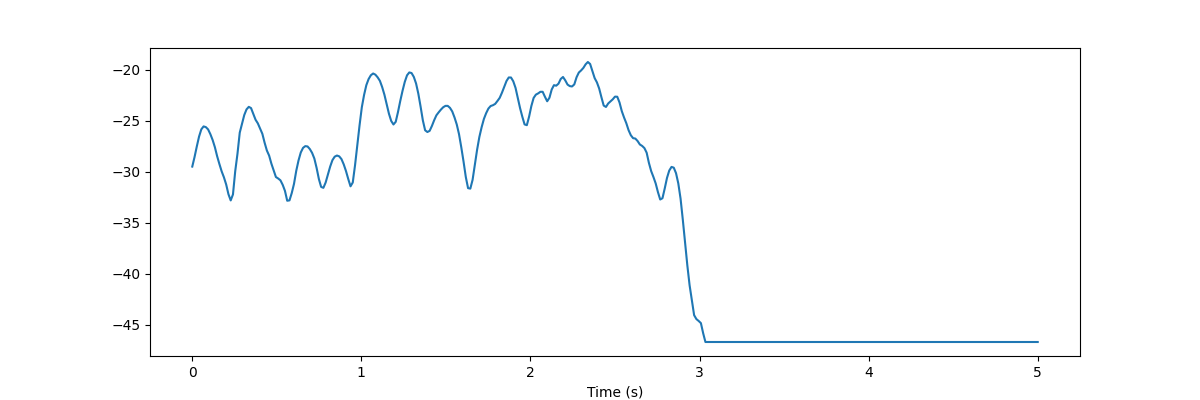

In [19]:
# Click anywhere to play from that point
clickable_audio_player(fooaudio, sr, data_to_plot=foodbrms)

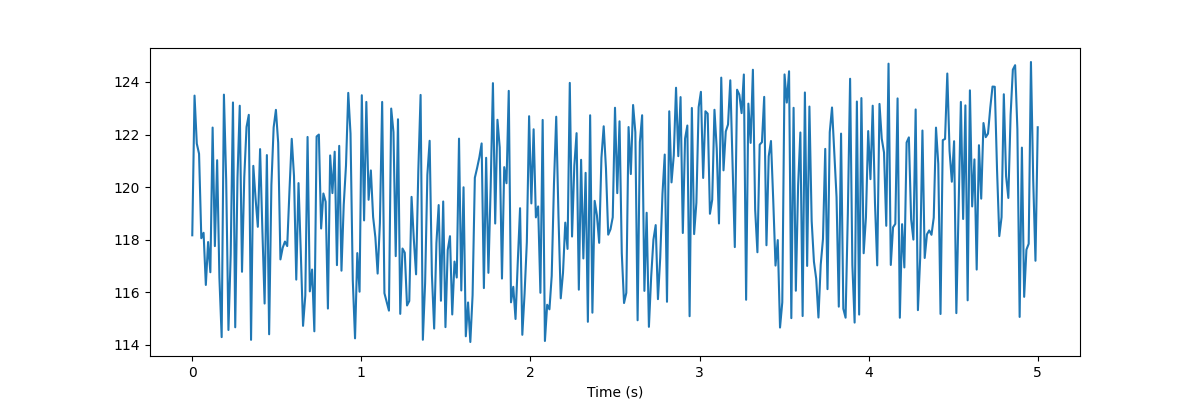

In [20]:
# Click anywhere to play from that point
clickable_audio_player(fooaudio, sr, data_to_plot=fooparam2)

<div style="width: 100%; height: 5px; background-color: DarkBlue;"></div>
<b>Now let's check the writes of the parameter sidecars</b>

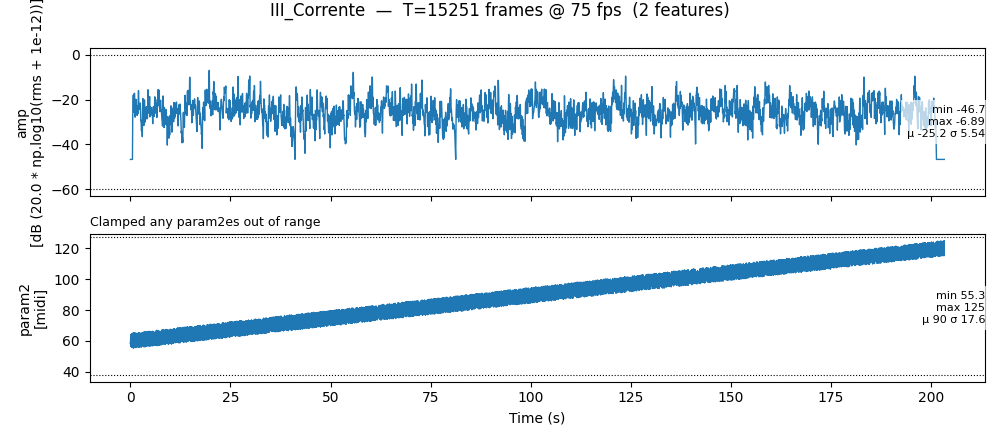

In [21]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

def plot_sidecar(root: str | Path, ecdc_rel: str | Path):
    """
    Visualize per-frame features saved as:
      <stem>.cond.npy   (T, D)
      <stem>.cond.json  {"features": {...}, "fps": ...}

    Stacks one subplot per feature, sharing the time axis.
    """
    root = Path(root)
    ecdc_rel = Path(ecdc_rel)
    if ecdc_rel.is_absolute():
        raise ValueError("ecdc_rel must be relative to root (as you pass into write_sidecar_features).")

    stem = (root / ecdc_rel).with_suffix("")  # drop .ecdc
    npy_path = stem.with_suffix(".cond.npy")
    json_path = stem.with_suffix(".cond.json")

    if not npy_path.exists() or not json_path.exists():
        raise FileNotFoundError(f"Missing sidecar(s): {npy_path} / {json_path}")

    # Load
    arr = np.load(npy_path).astype(np.float32, copy=False)   # (T, D)
    meta = json.loads(json_path.read_text(encoding="utf-8"))
    feats = meta.get("features", {})
    fps = float(meta.get("fps", 75.0))

    # Column order = insertion order of JSON "features"
    names = list(feats.keys())
    if arr.ndim != 2:
        raise ValueError(f"{npy_path.name} must be 2D (T, D); got {arr.shape}")
    T, D = arr.shape
    if D != len(names):
        print(f"Warning: columns (D={D}) != features listed ({len(names)}). "
              f"Will use min(D, len(names)).")
    D_use = min(D, len(names))

    t = np.arange(T) / fps  # seconds

    # Plot
    fig, axes = plt.subplots(D_use, 1, figsize=(10, 2.2*D_use), sharex=True)
    if D_use == 1:
        axes = [axes]

    for i in range(D_use):
        name = names[i]
        series = arr[:, i]
        fmeta = feats.get(name, {})
        units = fmeta.get("units", "")
        smin = fmeta.get("min", None)
        smax = fmeta.get("max", None)
        doc  = fmeta.get("doc_string", "")

        ax = axes[i]
        ax.plot(t, series, linewidth=1.0)
        ax.set_ylabel(f"{name}\n[{units}]" if units else name)
        if smin is not None and smax is not None:
            ax.axhline(smin, color='k', linestyle=':', linewidth=0.8)
            ax.axhline(smax, color='k', linestyle=':', linewidth=0.8)
        if doc:
            ax.set_title(doc, fontsize=9, loc="left")

        # Small stats in the right margin
        vmin = np.nanmin(series)
        vmax = np.nanmax(series)
        vmean = np.nanmean(series)
        vstd = np.nanstd(series)
        ax.text(1.0, 0.5,
                f"min {vmin:.3g}\nmax {vmax:.3g}\nμ {vmean:.3g} σ {vstd:.3g}",
                transform=ax.transAxes, ha="right", va="center", fontsize=8,
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

    axes[-1].set_xlabel("Time (s)")
    fig.suptitle(f"{stem.name}  —  T={T} frames @ {fps:g} fps  ({D_use} features)", y=0.995)
    fig.tight_layout()
    plt.show()

# --- usage (matches your variables) ---
plot_sidecar(audio_root, inputecdc)
